## Wake County - Restaurant Food Inspections Analysis

**Authors:** Shyamal Anadkat, Hearsch Jariwala, Christine Park

**Objective:** Develop a predictive model for Wake County officials in identifying restaurants at high risk for having a critical inspection violation so that officials can better allocate their resources for inspection. 

### Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)
 5. [Yelp LIVES data](https://www.yelp.com/healthscores/feeds)

Note: We're sourcing and pre-processing all the data in other notebooks. We have saved the pre-processed data in csv files so we can load them into dataframes in our main file here. If you do want to source them from here, you're free to do so.

In [1]:
#install packages if not already installed
!pip install tpot
!pip install scikit-learn --upgrade

In [2]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# import sklearn and tpot modules for preprocessing, pipelines, and modeling 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, accuracy_score, recall_score, plot_roc_curve, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import plot_confusion_matrix, PrecisionRecallDisplay
from tpot import TPOTClassifier

## Fetching Dataset #1: Restaurant Data 

In [3]:
restaurantsdf = pd.read_csv('preprocessed_restaurants.csv')
print("The restaurant dataframe has {} rows and {} columns".format(restaurantsdf.shape[0], restaurantsdf.shape[1]))
restaurantsdf.head()

The restaurant dataframe has 2380 rows and 12 columns


,OBJECTID,HSISID,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,PERMITID,X,Y,GEOCODESTATUS
0,1924822,4092016155,DAILY PLANET CAFE,11 W JONES ST,RALEIGH,27601,1.919708e+10,2012-04-12,2,-78.639431,35.782205,M
1,1924823,4092016161,HIBACHI 88,3416 POOLE RD,RALEIGH,27610,1.919231e+10,2012-04-18,4,-78.579533,35.767246,M
2,1924824,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,CARY,27511,1.919459e+10,2016-03-11,5,-78.778021,35.787986,M
3,1924825,4092018352,Prime Barbeque,403 KNIGHTDALE STATION RUN,KNIGHTDALE,27545,1.919374e+10,2020-04-22,6,-78.473566,35.797225,M
4,1924828,4092017192,STARBUCKS #19453,185 GRAND HILL PL,HOLLY SPRINGS,27540,1.919557e+10,2016-04-05,16,-78.849481,35.662665,M


## Fetching Dataset #2: Restaurant Inspection Data

In [4]:
inspectionsdf = pd.read_csv('preprocessed_inspections.csv')
print("The restaurant inspection dataframe has {} rows and {} columns".format(inspectionsdf.shape[0], inspectionsdf.shape[1]))
inspectionsdf.head()

The restaurant inspection dataframe has 32742 rows and 6 columns


,OBJECTID,HSISID,SCORE,DATE,TYPE,INSPECTOR
0,22332274,4092017542,94.5,2017-04-07,Inspection,Anne-Kathrin Bartoli
1,22332275,4092017542,92.0,2017-11-08,Inspection,Laura McNeill
2,22332276,4092017542,95.0,2018-03-23,Inspection,Laura McNeill
3,22332277,4092017542,93.5,2018-09-07,Inspection,Laura McNeill
4,22332278,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske


## Fetching Dataset #3: Restaurant Inspection Violation Data

In [5]:
violationsdf = pd.read_csv('preprocessed_violations.csv')
print("The restaurant inspection violation dataframe has {} rows and {} columns".format(violationsdf.shape[0], violationsdf.shape[1]))
violationsdf.head()

The restaurant inspection violation dataframe has 226604 rows and 11 columns


,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,SEVERITY,SHORTDESC,INSPECTEDBY,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE
0,190682112,4092016699,2017-03-24,Approved Source,NaN,NaN,Food obtained from approved source,Angela Myers,0.0,IN,NaN
1,190682241,4092030492,2021-06-14,Approved Source,NaN,NaN,Food obtained from approved source,David Adcock,1.0,OUT,NaN
2,190682242,4092017453,2017-10-18,Approved Source,NaN,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,VR
3,190682243,4092015754,2017-11-15,Approved Source,NaN,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,CDI
4,190682250,4092110015,2018-04-17,Approved Source,NaN,NaN,Food received at proper temperature,Laura McNeill,1.0,OUT,CDI


## Fetching Dataset #4: Yelp Review Data

In [6]:
yelpdatadf = pd.read_csv('preprocessed_yelpdata.csv')
print("The yelp review dataframe has {} rows and {} columns".format(yelpdatadf.shape[0], yelpdatadf.shape[1]))
display(yelpdatadf.head())

The yelp review dataframe has 2144 rows and 7 columns


,name,review_count,rating,price,phone,display_phone,category_title
0,Peace China,63,3.5,1,19196769968,(919) 676-9968,chinese
1,Asian Cafe,7,3.0,2,19196769968,(919) 676-9968,chinese
2,Northside Bistro & Cocktails,23,4.5,-1,19198905225,(919) 890-5225,american (new)
3,The Daily Planet Cafe,89,4.0,2,19197078060,(919) 707-8060,cafes
4,Hibachi 88,46,3.5,1,19192311688,(919) 231-1688,japanese


## Fetching Dataset #5: Daily Weather Data

In [7]:
weatherdatadf = pd.read_csv('preprocessed_weatherdata.csv')
print("The weather dataframe has {} rows and {} columns".format(weatherdatadf.shape[0], weatherdatadf.shape[1]))
weatherdatadf.head()

The weather dataframe has 1774 rows and 2 columns


,date,TAVG
0,2017-01-01,46.0
1,2017-01-02,50.0
2,2017-01-03,48.0
3,2017-01-04,56.0
4,2017-01-05,40.0


## Fetching Dataset #6: Daily Police Incident
- Using this as proxy for crime data

In [8]:
crimedatadf = pd.read_csv('preprocessed_crimedata.csv')
print("The crime dataframe has {} rows and {} columns".format(crimedatadf.shape[0], crimedatadf.shape[1]))
print("The crime dataframe has the following categories:")
print(crimedatadf['crime_category'].value_counts())
crimedatadf.head()

The crime dataframe has 239811 rows and 10 columns
The crime dataframe has the following categories:
MISCELLANEOUS                     57874
ASSAULT                           30682
LARCENY                           24361
DRUGS                             18623
FRAUD                             15176
VANDALISM                         15010
LARCENY FROM MV                   14928
ALL OTHER OFFENSES                10782
DRUG VIOLATIONS                    7510
WEAPONS VIOLATION                  6821
HUMANE                             6198
BURGLARY/RESIDENTIAL               6193
TRAFFIC                            4925
MV THEFT                           4729
SEX OFFENSES                       3012
ROBBERY                            2659
DISORDERLY CONDUCT                 2150
BURGLARY/COMMERCIAL                2084
STOLEN PROPERTY                    1705
UNAUTHORIZED MOTOR VEHICLE USE     1166
LIQUOR LAW VIOLATIONS               716
EMBEZZLEMENT                        666
JUVENILE           

,OBJECTID,crime_category,crime_code,crime_description,city,reported_date,reported_year,reported_month,reported_day,reported_dayofwk
0,12001,MISCELLANEOUS,81H,Miscellaneous/Missing Person (18 & over),RALEIGH,2017-01-15T03:28:00Z,2017,1,14,Saturday
1,12002,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-07-29T12:35:00Z,2017,7,29,Saturday
2,12007,MISCELLANEOUS,81K,Miscellaneous/Overdose Death,RALEIGH,2017-04-10T22:28:00Z,2017,4,10,Monday
3,12008,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-11-01T18:59:00Z,2017,11,1,Wednesday
4,12017,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-12-01T01:03:00Z,2017,11,30,Thursday


## Setting Up the Outcome Variable for the Risk Prediction Model

**1. Using the restaurant inspection scores**

We plan to potentially translate the restaurant inspection scores (numerical) to the Yelp LIVES grading scheme (ordinal A, B, C, D, F).

Note: LIVES is an open data standard which allows municipalities to publish restaurant inspection information to Yelp.


In [9]:
legend = pd.read_csv('YELP(LIVES)/legend.csv')
display(legend)

,minimum_score,maximum_score,description
0,90,100,A
1,80,89,B
2,70,79,C
3,60,69,D
4,0,59,F


In [10]:
def get_score_grade(legend_df, score):
    legend_dict = score_legend.to_dict('records') # creating a dictionary of the scoring categories
    
    for d in legend_dict:
        if score >= d['minimum_score'] and score <= d['maximum_score']:
                return d['description']

**2. Using "Critical/Not Critical" binary inspection violation classification scheme**

In [11]:
def aggregate_violations(rest_violation):

    rest_violation['CRITICAL'].fillna("No", inplace=True) # filling in missing values as "No"
    rest_violation['CRITICAL'] = rest_violation['CRITICAL'].apply(lambda x: (x=='Yes')) # converting "Yes/No" to "True/False"
    
    agg_critical = rest_violation.groupby(['HSISID','INSPECTDATE'],as_index=False)['CRITICAL'].agg('sum') # adding up the number of critical violations that individual restuaurants had per inspection date
    agg_critical['HAS CRITICAL'] = agg_critical['CRITICAL'] > 0 # defining a variable that flags whether there was at least one critical violation for a restaurant per inspection date
    
    return agg_critical

aggregate_violations(violationsdf.copy())

,HSISID,INSPECTDATE,CRITICAL,HAS CRITICAL
0,0,2020-12-21,2,True
1,0,2021-03-16,1,True
2,4092010018,2017-05-11,2,True
3,4092010018,2017-08-07,4,True
4,4092010018,2018-01-10,2,True
...,...,...,...,...
36882,4092300292,2020-09-30,1,True
36883,4092300292,2021-06-30,1,True
36884,4092300293,2021-05-10,0,False
36885,4092300293,2021-09-28,1,True


## Merging All Dataset to Create Final Dataframe with Relevant Features from Each Dataset

In [12]:
# Create copy of original DataFrames
rest_df = restaurantsdf.copy()
rest_inspect = inspectionsdf.copy()
rest_violation = violationsdf.copy()
yelp_df = yelpdatadf.copy()
temp_df = weatherdatadf.copy()
crime_df = crimedatadf.copy()
score_legend = legend.copy()

In [13]:
pd.set_option('display.max_columns', None) #to see all columns

def create_feature_table(rest_inspect, rest_df, rest_violation, temp_df, score_legend, crime_df, yelp_df):
# merging the inspectionsdf & restaurantsdf based on HSISID (which is primary key for identifying unique restaurants)
    firstmerge_df = rest_inspect.merge(rest_df, how='left', on=['HSISID'])
    
    firstmerge_df.drop(['OBJECTID_x', 'OBJECTID_y'], axis=1, inplace=True) # dropping irrelevant columns
    
# merging firstmerge with weather data based on date
    secondmerge_df = firstmerge_df.merge(temp_df, how='left', left_on='DATE', right_on='date')
    
    secondmerge_df.drop(['date'], axis=1, inplace=True) # dropping irrelevant columns
    
# merging secondmerge with yelp data based on name
    secondmerge_df["NAME"] = secondmerge_df["NAME"].str.lower()
    yelp_df["name"] = yelp_df["name"].str.lower()
    thirdmerge_df = secondmerge_df.merge(yelp_df, left_on="NAME", right_on="name", how="left")
    
    thirdmerge_df.drop_duplicates(['DATE', 'HSISID'], inplace=True) # dropping duplicates
    thirdmerge_df.drop(['display_phone', 'name', 'PHONENUMBER'], axis=1, inplace=True) # dropping irrelevant columns
    thirdmerge_df.dropna(subset=['review_count'], inplace=True) # dropping any missing values from the number of reviews column
    
# merging thirdmerge with crime data based on date
    # first get the number of police incidents per date 
    crime_df['reported_year'] = crime_df['reported_year'].astype(str)
    crime_df['reported_month'] = crime_df['reported_month'].astype(str)
    crime_df['reported_day'] = crime_df['reported_day'].astype(str)
    crime_df['crimedate'] = crime_df[['reported_year', 'reported_month', 'reported_day']].agg('-'.join, axis=1)
    crime_df['crimedate'] = pd.to_datetime(crime_df['crimedate'])
    crimedfagg = crime_df.groupby(['crimedate']).size()
    crimedfagg = pd.DataFrame(crimedfagg, columns=['crime_count']).reset_index()
    
    # second merge the two datasets
    fourthmerge_df = thirdmerge_df.copy()
    fourthmerge_df['DATE'] = pd.to_datetime(fourthmerge_df['DATE'])
    fourthmerge_df = fourthmerge_df.merge(crimedfagg, how='left', left_on='DATE', right_on='crimedate')
    
    fourthmerge_df=fourthmerge_df.drop(['crimedate'], axis=1) # dropping irrelevant columns
    fourthmerge_df = fourthmerge_df.drop_duplicates(subset=['SCORE', 'DATE', 'NAME']) # dropping duplicates

# applying the Yelp LIVES grading scheme function defined above to the restaurant inspection score (potential outcome variable 1)
    fourthmerge_df['SCORE GRADE'] = fourthmerge_df['SCORE'].apply(lambda s: get_score_grade(score_legend, s))

# merging fourthmerge with critical inspection violation data (potential outcome variable 2)
    agg_critical = aggregate_violations(rest_violation)
    fifthmerge = fourthmerge_df.copy()
    agg_critical['INSPECTDATE'] = pd.to_datetime(agg_critical['INSPECTDATE'])
    fifthmerge = fifthmerge.merge(agg_critical, how='inner', left_on=['DATE', 'HSISID'], right_on=['INSPECTDATE', 'HSISID'])
    
    fifthmerge.drop(['SCORE','SCORE GRADE'], axis=1, inplace=True) #dropping irrelevant columns
    #print(finale['HAS CRITICAL'].value_counts())

# finalizing all the features
    # including zipcode as feature
    final_features= fifthmerge.copy()
    final_features['POSTALCODE'] = final_features['POSTALCODE'].str.split('-').str[0]
    
    # including days open since inspection
    final_features['RESTAURANTOPENDATE'] = pd.to_datetime(final_features['RESTAURANTOPENDATE'])
    final_features['DAYS OPEN SINCE INSPECTION'] = (pd.to_datetime(final_features['DATE']) - pd.to_datetime(final_features['RESTAURANTOPENDATE'])).dt.days
    
    final_features = final_features.drop(['DATE','phone','ADDRESS1','GEOCODESTATUS','RESTAURANTOPENDATE'], axis=1) # dropping irrelevant columns
    
    #cleaning remaining features 
    final_features.CITY = final_features.CITY.str.lower()
    
    final_features['price'] = final_features['price'].fillna(final_features['price'].mode()[0])
    
    return final_features
    
final_features_df = create_feature_table(rest_inspect.copy(), rest_df.copy(), rest_violation.copy(), temp_df.copy(), score_legend.copy(), crime_df.copy(), yelp_df.copy())
print("The final features dataframe has {} rows and {} columns".format(final_features_df.shape[0], final_features_df.shape[1]))
final_features_df.head()

The final features dataframe has 6218 rows and 19 columns


,HSISID,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,category_title,crime_count,INSPECTDATE,CRITICAL,HAS CRITICAL,DAYS OPEN SINCE INSPECTION
0,4092017542,Inspection,Anne-Kathrin Bartoli,american deli,raleigh,27610,33.0,-78.61376,35.754388,53.0,10.0,3.5,1.0,chicken wings,149,2017-04-07,4,True,37
1,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,45.0,10.0,3.5,1.0,chicken wings,110,2017-11-08,4,True,252
2,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,42.0,10.0,3.5,1.0,chicken wings,142,2018-03-23,3,True,387
3,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,81.0,10.0,3.5,1.0,chicken wings,157,2018-09-07,2,True,555
4,4092017542,Inspection,Joanne Rutkofske,american deli,raleigh,27610,33.0,-78.61376,35.754388,60.0,10.0,3.5,1.0,chicken wings,145,2019-04-04,2,True,764


Note: We decided to drop the "Score"/"Score Grade" outcome variables because of significant class imbalance (skewed heavily to A and B with very few C and no D. 

**Hence we will use the "Has Critical" (T/F) variable as our final outcome variable.**

## Spltting Data into Training and Test Sets

In [14]:
# function for splitting data into training and test sets
def split_data(df):
    X = df.drop(['CRITICAL', 'HAS CRITICAL', 'HSISID'],axis=1)
    y = df['HAS CRITICAL']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0, shuffle=True)
    return X_train,X_test,y_train,y_test

print(final_features_df['HAS CRITICAL'].value_counts(dropna=False))
X_train, X_test, y_train, y_test = split_data(final_features_df)
print(X_train.shape, X_test.shape)

True     5301
False     917
Name: HAS CRITICAL, dtype: int64
(4974, 16) (1244, 16)


## Encoding the Features in Training and Test Sets

**Numerical features:** <br /> 
    Standardize each feature

**Categorical features:** <br /> 
    One-hot encode values for each feature

**Ordinal features:** <br /> 
    Ordinal encode  values for each feature

In [15]:
# defining numerical, categorical, and ordinal features for encoding the training set
numeric_features = ['review_count', 'crime_count', 'TAVG', 'DAYS OPEN SINCE INSPECTION', 'X', 'Y']
categorical_features = ['TYPE', 'INSPECTOR', 'CITY', 'category_title']
ordinal_features = ['NAME', 'INSPECTDATE', 'POSTALCODE', 'rating', 'price']

In [16]:
# function for encoding the training set
def encode_traindf(X, numeric_features, categorical_features, ordinal_features):

# numerical features
    scaler_num = StandardScaler() # defining scaler for numerical features 
    X[numeric_features] = scaler_num.fit_transform(X[numeric_features]) #scaling the numerical features
    
# categorical features
    for col in categorical_features:
        X[categorical_features] = X[categorical_features].astype(str)

    onehot_enc = OneHotEncoder(handle_unknown='ignore') # defining encoder
    onehot_enc.fit(X[categorical_features]) # fitting encoder 
    colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))  # getting the names of the new columns created
    
    onehot_vals = onehot_enc.transform(X[categorical_features]).toarray() # transforming the data
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index) # putting the transformed data into dataframe
    X = pd.concat([X,enc_df],axis=1).drop(categorical_features,axis=1) # adding onehot columns back onto original dataframe and dropping the original columns

#ordinal features
    ord_enc =  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) # defining encoder
    X[ordinal_features] = ord_enc.fit_transform(X[ordinal_features]) # fitting encoder

    scaler_ord = StandardScaler() # defining scaler for ordinal features
    X[ordinal_features] = scaler_ord.fit_transform(X[ordinal_features]) # scaling the ordinal features
    
    return X, ord_enc, scaler_num, scaler_ord, onehot_enc

X_train, ord_enc, scaler_num, scaler_ord, onehot_enc = encode_traindf(X_train.copy(), numeric_features, categorical_features, ordinal_features)
print("The training set has {} rows and {} columns".format(X_train.shape[0], X_train.shape[1]))
display(X_train.head())

The training set has 4974 rows and 180 columns


C:\Users\parks\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,NAME,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,crime_count,INSPECTDATE,DAYS OPEN SINCE INSPECTION,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Anne-Kathrin Bartoli,INSPECTOR_Ashley Whittington,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dimitri Parker,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_title_tapas/small plates,category_title_tea rooms,category_title_tex-mex,catego

In [17]:
# function for encoding the test set

def encode_testdf(X, ord_enc, scaler_num, scaler_ord, onehot_enc, numeric_features, categorical_features, ordinal_features):

# numerical features
    scaler_num = StandardScaler() # defining scaler for numerical features 
    X[numeric_features] = scaler_num.fit_transform(X[numeric_features]) #scaling the numerical features
    
# categorical features
    for col in categorical_features:
        X[categorical_features] = X[categorical_features].astype(str)
    
    onehot_enc.fit(X[categorical_features]) # fitting encoder 
    colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))  # getting the names of the new columns created
            
    onehot_vals = onehot_enc.transform(X[categorical_features]).toarray() # transforming the data
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index) # putting the transformed data into dataframe
    X = pd.concat([X,enc_df],axis=1).drop(categorical_features,axis=1) # adding onehot columns back onto original dataframe and dropping the original col

# ordinal features
    X[ordinal_features] = ord_enc.transform(X[ordinal_features]) # fitting encoder
    X[ordinal_features] = scaler_ord.transform(X[ordinal_features]) # scaling the ordinal features
    
    return X

X_test = encode_testdf(X_test.copy(), ord_enc, scaler_num, scaler_ord, onehot_enc, numeric_features, categorical_features, ordinal_features)
print("The test set has {} rows and {} columns".format(X_test.shape[0], X_test.shape[1]))
display(X_test.head())

C:\Users\parks\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The test set has 1244 rows and 164 columns


,NAME,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,crime_count,INSPECTDATE,DAYS OPEN SINCE INSPECTION,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Anne-Kathrin Bartoli,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dimitri Parker,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_golf,category_title_greek,category_title_hawaiian,category_title_himalayan/nepalese,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_title_tapas/small plates,category_title_tex-mex,category_title_thai,category_title_vegan,category_title_venezuelan,category_title_venues & event spaces,category_title_vietnamese,category_title_wine bars
2235,0.230701,-1.339485,9891.0,-0.121508,0.101987,-1.324296,-0.584991,-0.190748,-0.636646,1.957735,-1.266204,1.163887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0

## Feature Selection Using Univariate Analysis

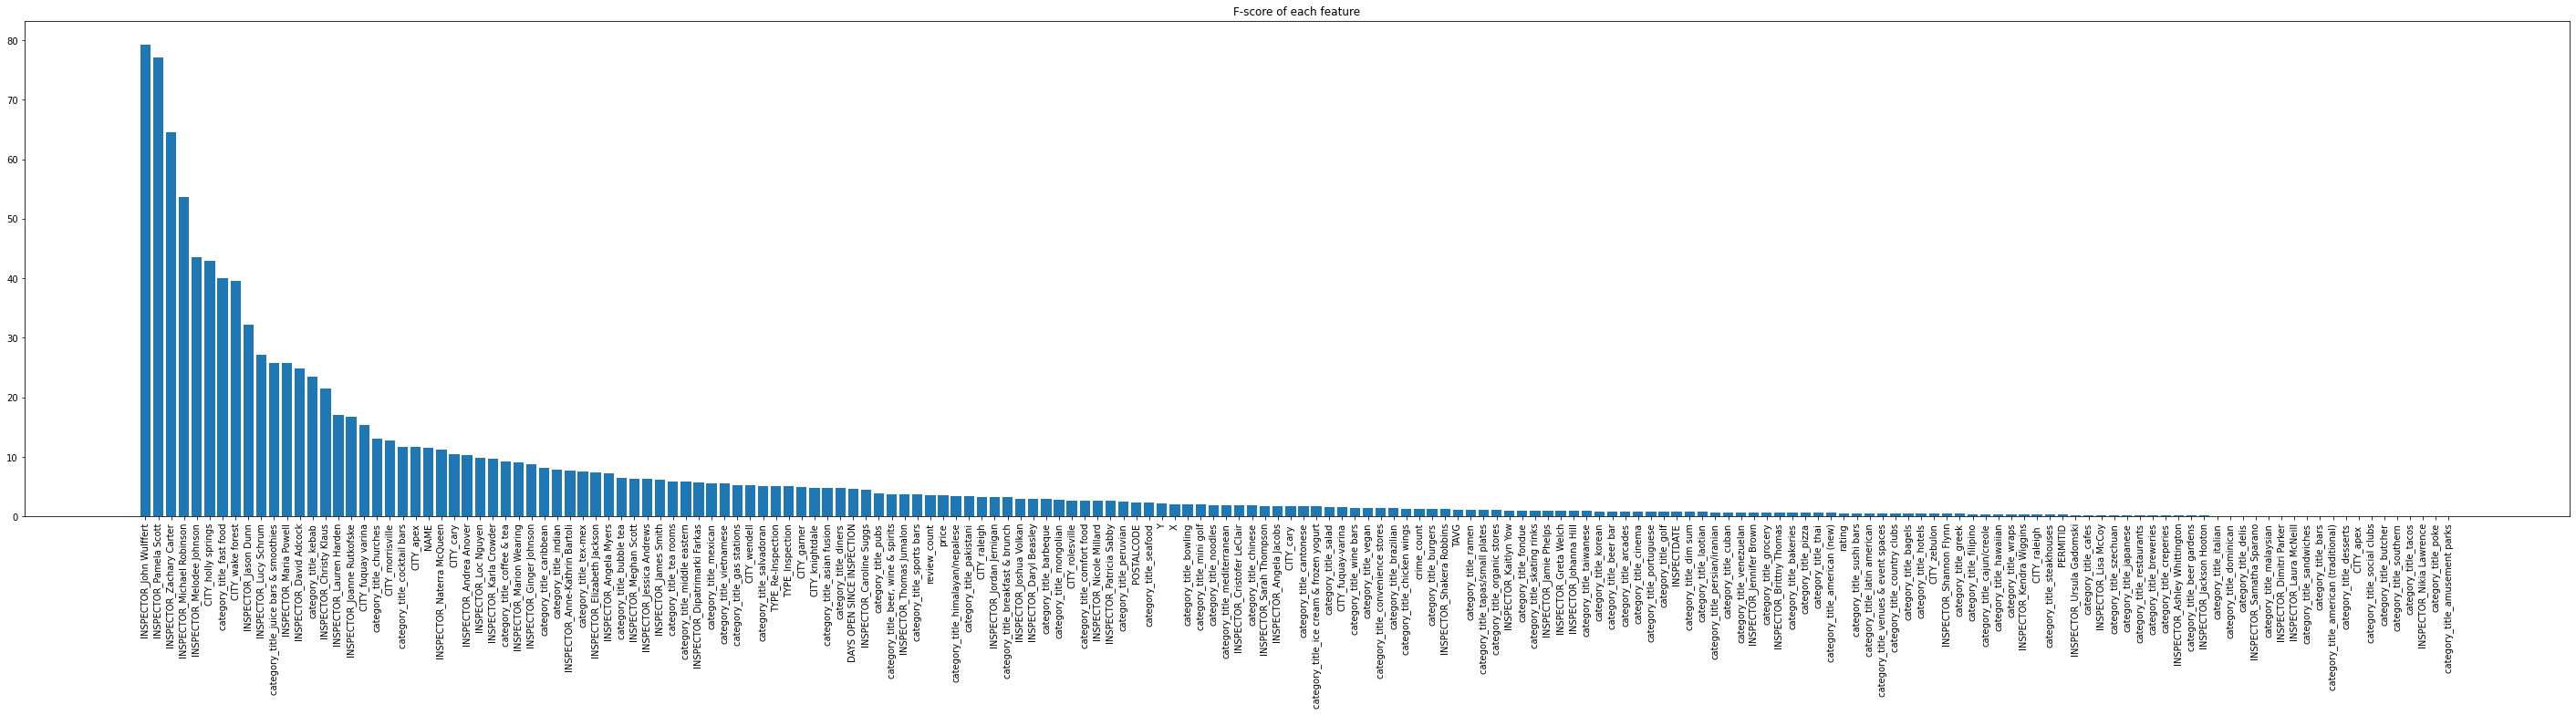

,Feature,F-Score
38,INSPECTOR_John Wulffert,79.309460
57,INSPECTOR_Pamela Scott,77.166420
65,INSPECTOR_Zachary Carter,64.582802
53,INSPECTOR_Michael Robinson,53.722737
52,INSPECTOR_Melodee Johnson,43.606533
73,CITY_holly springs,42.924207
121,category_title_fast food,40.068234
79,CITY_wake forest,39.522934
33,INSPECTOR_Jason Dunn,32.232950
48,INSPECTOR_Lucy Schrum,27.142812


In [18]:
def univariate_feature_selection(X_train, y_train):   
    # Evaluate features using ANOVA (score_func = f_classif)
    ftest = SelectKBest(score_func=f_classif, k='all')
    ftest.fit(X_train,y_train)
    f_scores = pd.DataFrame(ftest.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    f_scores = pd.concat([dfcolumns,f_scores], axis=1)
    f_scores.columns = ['Feature','F-Score']  
    f_scores = f_scores.sort_values(by='F-Score', ascending=False)

    # Plot scores
    plt.figure(figsize=(50,10))
    plt.bar(x=f_scores['Feature'],height=f_scores['F-Score'])
    plt.xticks(rotation=90)
    plt.title('F-score of each feature')
    plt.show()
    display(f_scores.head(20))
    
univariate_feature_selection(X_train, y_train)

## Using the TPOT Classifier to Find the Optimal Model

In [19]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=3, max_eval_time_mins=0.04, population_size=40, scoring='f1')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.9210412055004648

Generation 2 - Current best internal CV score: 0.9215632588198069

Generation 3 - Current best internal CV score: 0.9215632588198069

3.00 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVC(SelectFwe(input_matrix, alpha=0.021), C=10.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.01)


C:\Users\parks\miniconda3\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- INSPECTOR_Ashley Whittington
- category_title_arcades
- category_title_beer bar
- category_title_bubble tea
- category_title_cocktail bars
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 164 features, but SelectFwe is expecting 180 features as input.

**We obtained the following results from trying out various models:**

1. **KNeighborsClassifier**(input_matrix, n_neighbors=78, p=2, weights=uniform) <br /> 
F1 score = 0.9177903436276642

2. **KNeighborsClassifier**(RobustScaler(input_matrix), n_neighbors=24, p=2, weights=distance) <br />
F1 score = 0.9171075837742504

3. **DecisionTreeClassifier**(SelectPercentile(input_matrix, percentile=98), criterion=gini, max_depth=4, min_samples_leaf=10, min_samples_split=7) <br />
F1 score = 0.8553639846743295

4. **LogisticRegression**(SelectPercentile(MinMaxScaler(input_matrix), percentile=31), C=15.0, dual=False, penalty=l2) <br />
F1 score = 0.8545016077170418

# Training, Testing, and Evaluation with the Final Model

In [ ]:
# using KNN as our final model of choice
knn_model = KNeighborsClassifier(n_neighbors=78)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_accuracy = np.round(np.sum((knn_preds==y_test)/len(y_test)),3)
print(knn_accuracy)

knn_cm = confusion_matrix(y_test, knn_preds)
plot_confusion_matrix(knn_model, X_test, y_test)